# Лабораторная работа №3

## Выполнил Филенков Алексей Дмитриевич

Imports

In [58]:
import os
import json
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pprint import pprint
from tqdm import tqdm
from scipy.stats import norm
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

## Загрузка данных

Я собрал 4 Датасета по регионам нашей страны, по нескольким признакам. Изучим их корреляцию

In [18]:
df1 = pd.read_csv("database/Процент_русских.csv",encoding="UTF-8").drop(columns=["Unnamed: 0"])
df2 = pd.read_csv("database/Средний_возраст.csv",encoding="UTF-8").drop(columns=["Unnamed: 0"])
df3 = pd.read_csv("database/Процент_людей_с_высшим_образованием.csv",encoding="UTF-8").drop(columns=["2010"])
df4 = pd.read_csv("database/Доля_детей.csv",encoding="UTF-8").drop(columns=["2012"])
df1.columns = ("Область","Процент русских")
df2.columns = ("Область","Средний возраст")
df3.columns = ("Область","Поцент с высшим образованием")
df4.columns = ("Область","Доля детей")
df4 = df4.groupby(by="Область").mean()
df = df1
df = pd.merge(left=df,right=df2,how="inner",on="Область")
df = pd.merge(left=df,right=df3,how="inner",on="Область")
df = pd.merge(left=df,right=df4,how="inner",on="Область")
df

,Область,Процент русских,Средний возраст,Поцент с высшим образованием,Доля детей
0,Алтайский край,93.927663,40.08,17.0,18.000000
1,Амурская область,94.328310,37.90,18.0,19.450000
2,Архангельская область,95.580243,40.15,17.0,17.466667
3,Астраханская область,67.573913,38.52,18.0,19.000000
4,Башкортостан,36.050489,38.57,17.0,19.333333
...,...,...,...,...,...
79,Чувашия,26.860039,39.50,19.0,18.016667
80,Чукотский автономный округ,52.491833,34.85,21.0,22.500000
81,Якутия,37.837020,34.11,21.0,24.216667
82,Ямало-Ненецкий автономный округ,61.738628,33.33,25.0,22.800000


## Лаб 2

Построим распределения полученных величин

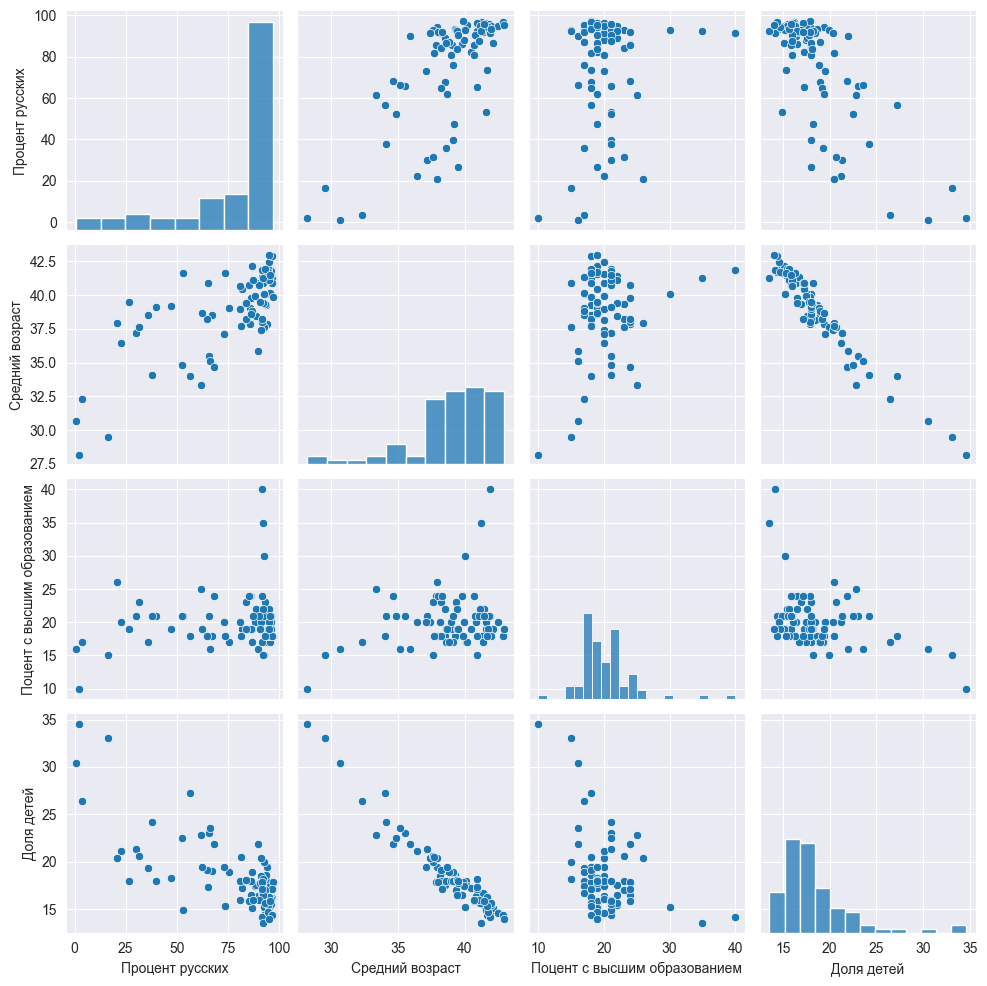

In [23]:
sns.pairplot(df.drop(columns="Область"))

Построим матрицу корреляции между признаками

<Axes: >

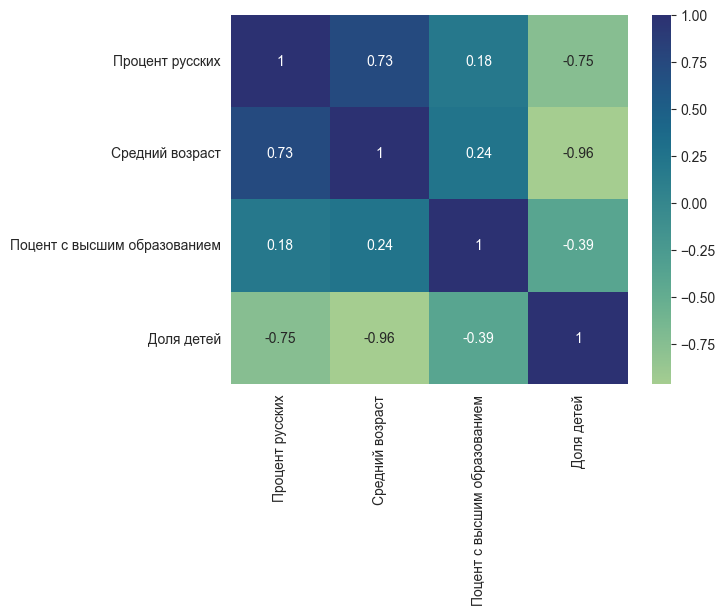

In [39]:
corr = df.drop(columns=["Область"]).corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            cmap="crest")

Ручной подсчёт корреляции Пирсона между ключевыми признаками

In [29]:
df

,Область,Процент русских,Средний возраст,Поцент с высшим образованием,Доля детей
0,Алтайский край,93.927663,40.08,17.0,18.000000
1,Амурская область,94.328310,37.90,18.0,19.450000
2,Архангельская область,95.580243,40.15,17.0,17.466667
3,Астраханская область,67.573913,38.52,18.0,19.000000
4,Башкортостан,36.050489,38.57,17.0,19.333333
...,...,...,...,...,...
79,Чувашия,26.860039,39.50,19.0,18.016667
80,Чукотский автономный округ,52.491833,34.85,21.0,22.500000
81,Якутия,37.837020,34.11,21.0,24.216667
82,Ямало-Ненецкий автономный округ,61.738628,33.33,25.0,22.800000


In [45]:
def cov(X,Y):
    return np.sum((X-X.mean())*(Y-Y.mean()))/X.shape[0]

def corr(X,Y):
    return cov(X,Y)/(X.std()*Y.std())

print(f"Явная отрицательная ковариаци: {cov(df['Доля детей'],df['Средний возраст'])}")
print(f"Явная положительная ковариаци: {cov(df['Процент русских'],df['Средний возраст'])}")

print(f"Явная отрицательная корреляция: {corr(df['Доля детей'],df['Средний возраст'])}")
print(f"Явная положительная корреляция: {corr(df['Процент русских'],df['Средний возраст'])}")

Явная отрицательная ковариаци: -11.100306216931218
Явная положительная ковариаци: 54.85488483083459
Явная отрицательная корреляция: -0.9523196212905328
Явная положительная корреляция: 0.7168710200676494


Вывод: 
1) чем больше детей тем меньше средний возраст)
2) чем больше людей в возрасте, тем больше русских. (Видимо потмоу что приезжие зачастую молодые)


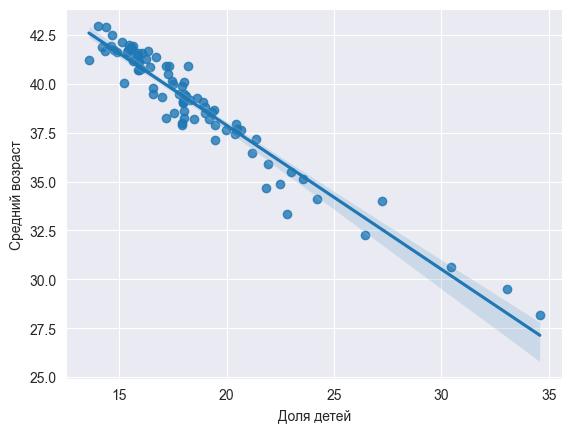

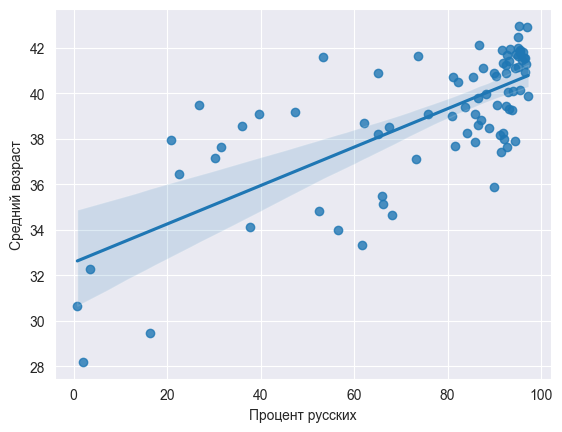

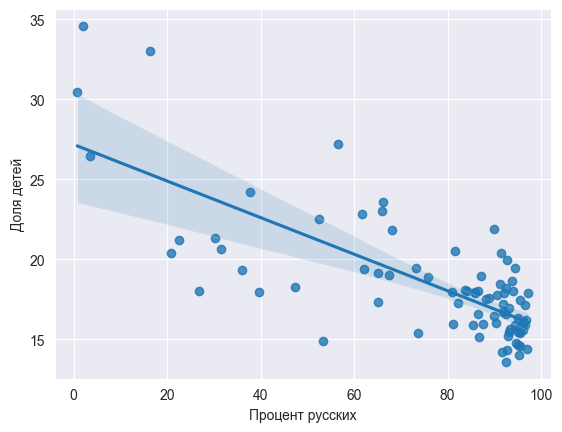

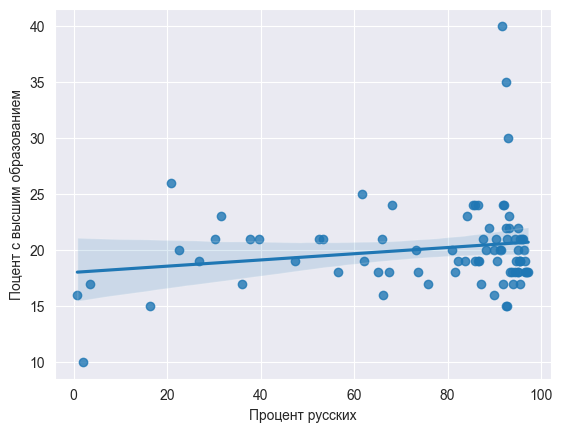

In [52]:
sns.regplot(x="Доля детей", y="Средний возраст", data=df)
plt.show()
sns.regplot(x="Процент русских", y="Средний возраст", data=df)
plt.show()
sns.regplot(x="Процент русских", y="Доля детей", data=df)
plt.show()
sns.regplot(x="Процент русских", y="Поцент с высшим образованием", data=df)
plt.show()

In [60]:
# Подготовка данных
X = df[['Доля детей']]  # Независимая переменная
y = df['Средний возраст']  # Зависимая переменная

# Создание модели линейной регрессии
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Вычисление R^2
r2 = r2_score(y, y_pred)
print(f'Коэффициент детерминации R^2: {r2}')


# Подготовка данных
X = df[['Процент русских']]  # Независимая переменная
y = df['Средний возраст']  # Зависимая переменная

# Создание модели линейной регрессии
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Вычисление R^2
r2 = r2_score(y, y_pred)
print(f'Коэффициент детерминации R^2: {r2}')


Коэффициент детерминации R^2: 0.9288976247185259
Коэффициент детерминации R^2: 0.526361887533306


Случайная выборка

In [65]:
df.to_numpy()

array([['Алтайский край', 93.927662645963, 40.08, 17.0, 18.0],
       ['Амурская область', 94.3283095604118, 37.9, 18.0, 19.45],
       ['Архангельская область', 95.580243339124, 40.15, 17.0,
        17.46666666666667],
       ['Астраханская область', 67.5739132715968, 38.52, 18.0, 19.0],
       ['Башкортостан', 36.0504890910555, 38.57, 17.0,
        19.333333333333332],
       ['Белгородская область', 94.3661262171535, 41.13, 21.0,
        15.883333333333333],
       ['Брянская область', 96.7031913261392, 41.28, 18.0,
        16.233333333333334],
       ['Бурятия', 66.0504375907066, 35.5, 21.0, 23.016666666666666],
       ['Владимирская область', 95.5820106016319, 41.86, 19.0,
        15.533333333333333],
       ['Волгоградская область', 90.0076005020229, 40.87, 20.0,
        16.433333333333334],
       ['Вологодская область', 97.2660112086984, 39.89, 18.0,
        17.916666666666668],
       ['Воронежская область', 95.5028946373578, 41.92, 21.0, 14.6],
       ['Дагестан', 3.597043936

In [109]:
sample = df.sample(20,replace=False,random_state=1)
sample

,Область,Процент русских,Средний возраст,Поцент с высшим образованием,Доля детей,Age Group
10,Вологодская область,97.266011,39.89,18.0,17.916667,"(30.0, 40.0]"
67,Татарстан,39.714176,39.11,21.0,17.983333,"(30.0, 40.0]"
59,Саратовская область,87.554039,41.11,21.0,15.933333,"(40.0, 42.0]"
33,Ленинградская область,92.746116,41.70,21.0,14.350000,"(40.0, 42.0]"
83,Ярославская область,95.965589,41.47,21.0,15.866667,"(40.0, 42.0]"
77,Челябинская область,83.797389,39.40,19.0,18.083333,"(30.0, 40.0]"
34,Липецкая область,96.263223,41.57,20.0,16.050000,"(40.0, 42.0]"
38,Москва,91.650445,41.89,40.0,14.200000,"(40.0, 42.0]"
47,Орловская область,96.042975,41.80,21.0,15.600000,"(40.0, 42.0]"
56,Рязанская область,95.111953,42.49,20.0,14.650000,NaN


Разделим на страты по 10 лет

In [110]:
bins = [28, 30, 40, 42]
df['Age Group'] = pd.cut(df['Средний возраст'], bins=bins)

# Стратифицированная выборка по возрастным группам
stratified_sample = df.groupby('Age Group').apply(lambda x: x.sample(n=7, replace=True, random_state=2)).reset_index(drop=True)

# Печать результата
stratified_sample

,Область,Процент русских,Средний возраст,Поцент с высшим образованием,Доля детей,Age Group
0,Республика Тыва,16.268837,29.49,15.0,33.033333,"(28, 30]"
1,Чечня,1.925188,28.20,10.0,34.583333,"(28, 30]"
2,Чечня,1.925188,28.20,10.0,34.583333,"(28, 30]"
3,Республика Тыва,16.268837,29.49,15.0,33.033333,"(28, 30]"
4,Республика Тыва,16.268837,29.49,15.0,33.033333,"(28, 30]"
5,Чечня,1.925188,28.20,10.0,34.583333,"(28, 30]"
6,Республика Тыва,16.268837,29.49,15.0,33.033333,"(28, 30]"
7,Челябинская область,83.797389,39.40,19.0,18.083333,"(30, 40]"
8,Кемеровская область,93.698739,39.28,18.0,18.633333,"(30, 40]"
9,Ингушетия,0.784851,30.65,16.0,30.450000,"(30, 40]"


In [111]:
print("Генеральная совокупность:")
display(df.drop(columns=["Область","Age Group"]).mean())
print("Случайная выборка:")
display(sample.drop(columns=["Область","Age Group"]).mean())
print("Стратифицированная выборка:")
display(stratified_sample.drop(columns=["Область","Age Group"]).mean())

Генеральная совокупность:


Процент русских                 76.586837
Средний возраст                 39.035476
Поцент с высшим образованием    20.121951
Доля детей                      18.422222
dtype: float64

Случайная выборка:


Процент русских                 81.831532
Средний возраст                 40.143500
Поцент с высшим образованием    19.750000
Доля детей                      17.505000
dtype: float64

Стратифицированная выборка:


Процент русских                 56.662100
Средний возраст                 35.930476
Поцент с высшим образованием    18.714286
Доля детей                      23.160317
dtype: float64

In [116]:
q = (1-0.9)/2
X = df["Процент русских"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")
X = df["Средний возраст"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")
X = df["Поцент с высшим образованием"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")
X = df["Доля детей"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")

(17.613624293471098;135.5600489473674)
(28.152052699646585;49.91889968130579)
(13.147657645812206;27.096244793212183)
(12.277948565223129;24.56649587922132)


Все значения попали в доверительный интервал 0.9

In [118]:
q = (1-0.95)/2
X = df["Процент русских"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")
X = df["Средний возраст"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")
X = df["Поцент с высшим образованием"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")
X = df["Доля детей"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")

(63.8629812102596;89.3106920305789)
(29.01676216722394;49.05419021372843)
(13.583550994168455;26.660351444855934)
(12.365145465783467;24.47929897866098)


Все значения выборок попали в доверительный интервал 0.95, кроме Процента русских для стратифицированной выборки

In [119]:
q = (1-0.99)/2
X = df["Процент русских"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")
X = df["Средний возраст"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")
X = df["Поцент с высшим образованием"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")
X = df["Доля детей"]
print(f"({X.mean()-X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))};{X.mean()+X.quantile(q)*(X.std()/np.sqrt(X.shape[0]))})")

(73.06665755501828;80.10701568582022)
(29.680156461880944;48.39079591907144)
(14.880333705528296;25.363568733496095)
(12.556126212957778;24.28831823148667)


Для доверительного интервала 0.99 полностью не подошли данные выборок по Проценту русских, но остальные находятся внутри

## Вывод

В результате данной лабораторной работы было рассмотрено несколько зависимых распределений. Найдены разные закономерности в данных. Рассчитана линейная апроксимация для наиболее зависимых распределений, а так же рассмотрены разные выборки и доерительные интервалы их среднего. Этот эксперимент показал, что стратификация по возрасту может быть не лучшим решением для таких данных.